In [1]:
SAMPLERATE = 44100 # Hz
SAMPLES = 2**14
FREQ = 1000 # Hz
AMPLITUDE = 1e-14

DURATION = SAMPLES / SAMPLERATE
print("simulation duration: {:.2f}s".format(DURATION))

simulation duration: 0.37s


In [2]:
import numpy as np
from numba import jit
from plot_utils import *
init_plot(DURATION, FREQ, SAMPLERATE)

generate the input data

[FrameInfo(frame=<frame at 0x7f36779e6040, file '/home/anuejn/code/class-d-igital/modulator-simulation/plot_utils.py', line 48, code plot_signals>, filename='/home/anuejn/code/class-d-igital/modulator-simulation/plot_utils.py', lineno=47, function='plot_signals', code_context=['    stack = inspect.stack()\n'], index=0), FrameInfo(frame=<frame at 0x7f36769c9230, file '<ipython-input-3-adb47e12aa31>', line 4, code <module>>, filename='<ipython-input-3-adb47e12aa31>', lineno=4, function='<module>', code_context=['plot_signals(input_samples)\n'], index=0), FrameInfo(frame=<frame at 0x557c855b25a0, file '/home/anuejn/code/XC9500/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py', line 3319, code run_code>, filename='/home/anuejn/code/XC9500/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py', lineno=3319, function='run_code', code_context=['                    exec(code_obj, self.user_global_ns, self.user_ns)\n'], index=0), FrameInfo(frame=<frame at 0x557c855b

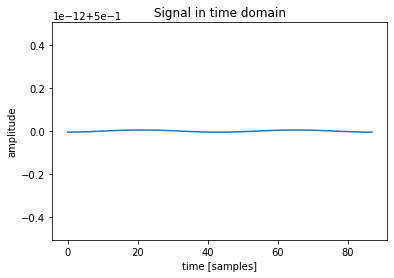

NameError: name 'stack' is not defined

In [3]:
t = np.linspace(0, DURATION, SAMPLES)
sin = np.sin(t * 2 * np.pi * FREQ) * AMPLITUDE
input_samples = (sin + 1) / 2
plot_signals(input_samples)

next, we pass the input through a modulator

In [ ]:
from scipy.signal import resample

def modulate_pwm(input, *, n_bits, oversampling_ratio):
    resampled = resample(input, len(input) * oversampling_ratio)
    
    quantized_samples = np.array(np.round(resampled * 2**n_bits), dtype=int)
    
    @jit(nopython=True, parallel=True)
    def loop():
        output = np.zeros(len(resampled) * 2**n_bits)
        for i, sample in enumerate(quantized_samples):
            for j in range(sample):
                output[(i * 2**n_bits) + j] = True
        return output
    return loop()

modulated = modulate_pwm(input_samples, n_bits=8, oversampling_ratio=10)
plot_signals(modulated)

In [ ]:
oversampled_rate = len(modulated) / DURATION
print("oversampled rate is {:.2f}Mhz. oversampling factor is {}".format((oversampled_rate / 10e6), oversampled_rate // SAMPLERATE))

changes = np.sum(modulated[:-1] != modulated[1:]) / 2
switching_rate = changes / DURATION
print("average switching frequency is {:.2f}kHz".format(switching_rate / 1000))

now we downsample the signal again and do lowpass filtering
this step can be further tweaked and needs to reflect the parameters of the real hardware

In [ ]:
from scipy.signal import decimate
decimated = decimate(modulated, int(oversampled_rate / SAMPLERATE), ftype="fir")
plot_signals(decimated)

then we analyze the quality of the downsampled signal

In [ ]:
from scipy.signal import correlate

shift = 0 # np.argmax(correlate(input_samples, decimated)) % int((1 / FREQ) * SAMPLERATE)
print("phase shift is {} samples ({:.2f}ms)".format(shift, shift / SAMPLERATE * 1000))

decimated_s, input_s = decimated[:(-shift if shift != 0 else len(decimated))], input_samples[shift:]

noise = decimated_s - input_s

plot_signals(input_s, decimated_s, noise)
plot_spectrum(noise)
noise_level = np.abs(np.average(noise))
print("Noise Level: {:.2f}dB".format(np.log10(noise_level) * 10))
print("SNR: {:.2f}dB".format(np.log10(np.average(input_samples) / noise_level) * 10))